# Market Prices

Data obtained from [REN Datahub](https://mercado.ren.pt/PT/Electr/InfoMercado/InfOp/MercOmel/Paginas/Precos.aspx).

In [53]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import xgboost as xgb

warnings.filterwarnings('ignore')


In [2]:
df = pd.read_excel("../data/PrecoMerc.xlsx")
df.head()

,Date,Hour,Session,Price - PT [€/MWh],Price - ES [€/MWh]
0,2008-07-01,1,0,70.31,63.11
1,2008-07-01,2,0,64.54,58.55
2,2008-07-01,3,0,64.08,55.85
3,2008-07-01,4,0,63.50,55.00
4,2008-07-01,5,0,63.28,53.96


In [3]:
df.columns = ["date", "hour", "session", "price_pt", "price_es"]
df = df[df['session'] == 0][["date", "hour", "price_pt"]]
df.head()

,date,hour,price_pt
0,2008-07-01,1,70.31
1,2008-07-01,2,64.54
2,2008-07-01,3,64.08
3,2008-07-01,4,63.50
4,2008-07-01,5,63.28


In [4]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["hour"] = pd.to_timedelta(df["hour"], unit="h")
df["date"] = df["date"] + df["hour"]
df.head()

,date,hour,price_pt
0,2008-07-01 01:00:00,0 days 01:00:00,70.31
1,2008-07-01 02:00:00,0 days 02:00:00,64.54
2,2008-07-01 03:00:00,0 days 03:00:00,64.08
3,2008-07-01 04:00:00,0 days 04:00:00,63.50
4,2008-07-01 05:00:00,0 days 05:00:00,63.28


In [5]:
df = df[["date", "price_pt"]]
df.rename(columns={"price_pt": "price"}, inplace=True)
df.head()

,date,price
0,2008-07-01 01:00:00,70.31
1,2008-07-01 02:00:00,64.54
2,2008-07-01 03:00:00,64.08
3,2008-07-01 04:00:00,63.50
4,2008-07-01 05:00:00,63.28


In [6]:
# df.to_csv("../data/MarketPricePT.csv", index=False)

# Simulation

In this section, we will simulate the management system of the REC.

## Baseline

In [7]:
try:
    df
except NameError:
    df = pd.read_csv("../data/MarketPricePT.csv")

In [33]:
energy_df = pd.read_csv("../data/BANES_v4_featureimportance.csv")
energy_df.head()

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336
0,##Bishop Sutton Primary School Electricity,2017-01-08 00:00:00+00:00,0.000,0.000,0.000,0.005,0.000,0.000,0.000
1,##Bishop Sutton Primary School Electricity,2017-01-08 00:30:00+00:00,0.000,0.000,0.005,0.005,0.005,0.000,0.000
2,##Bishop Sutton Primary School Electricity,2017-01-08 01:00:00+00:00,0.000,0.000,0.005,0.006,0.005,0.005,0.000
3,##Bishop Sutton Primary School Electricity,2017-01-08 01:30:00+00:00,0.006,0.000,0.006,0.005,0.006,0.005,0.005
4,##Bishop Sutton Primary School Electricity,2017-01-08 02:00:00+00:00,0.005,0.006,0.005,0.005,0.005,0.006,0.005


In [34]:
# pick 10 locations at random
locs = energy_df.sample(10, random_state=1).index.tolist()
locations = energy_df.iloc[locs]["location"]
assert len(locations) == 10 and len(np.unique(locations)) == 10
energy_df = energy_df[energy_df["location"].isin(locations)]
energy_df.head()

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.342,0.339,0.332,0.342,0.334,0.335,0.334
45651,##Northgate House Electricity Supply 2,2017-01-08 00:30:00+00:00,0.343,0.342,0.335,0.337,0.333,0.334,0.335
45652,##Northgate House Electricity Supply 2,2017-01-08 01:00:00+00:00,0.342,0.343,0.338,0.336,0.338,0.333,0.334
45653,##Northgate House Electricity Supply 2,2017-01-08 01:30:00+00:00,0.335,0.342,0.341,0.335,0.341,0.338,0.333
45654,##Northgate House Electricity Supply 2,2017-01-08 02:00:00+00:00,0.338,0.335,0.342,0.335,0.345,0.341,0.338


In [35]:
model: xgb.XGBRegressor = pickle.load(open("../models/model_v1.pkl", "rb"))

In [36]:
X = energy_df.drop(["location", "time", "energy"], axis=1)
y = model.predict(X)

In [37]:
energy_df["energy_pred"] = y
energy_df.head()

,location,time,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred
45650,##Northgate House Electricity Supply 2,2017-01-08 00:00:00+00:00,0.342,0.339,0.332,0.342,0.334,0.335,0.334,0.347339
45651,##Northgate House Electricity Supply 2,2017-01-08 00:30:00+00:00,0.343,0.342,0.335,0.337,0.333,0.334,0.335,0.347339
45652,##Northgate House Electricity Supply 2,2017-01-08 01:00:00+00:00,0.342,0.343,0.338,0.336,0.338,0.333,0.334,0.347339
45653,##Northgate House Electricity Supply 2,2017-01-08 01:30:00+00:00,0.335,0.342,0.341,0.335,0.341,0.338,0.333,0.347339
45654,##Northgate House Electricity Supply 2,2017-01-08 02:00:00+00:00,0.338,0.335,0.342,0.335,0.345,0.341,0.338,0.332923


In [38]:
# group by date and sum the energy_pred
energy_df = energy_df.groupby("time").sum()
energy_df.head()

,energy,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy_pred
time,,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.4145,15.6905,19.0515,13.7410,13.665,10.4265,12.346559
2017-01-08 00:30:00+00:00,15.5335,12.1005,15.7690,16.3645,14.3410,13.741,13.6650,13.528800
2017-01-08 01:00:00+00:00,15.8120,15.5335,15.9685,15.1790,13.9740,14.341,13.7410,15.156461
2017-01-08 01:30:00+00:00,15.2760,15.8120,15.6965,14.6085,13.7320,13.974,14.3410,15.276405
2017-01-08 02:00:00+00:00,15.6635,15.2760,15.5890,14.2770,13.7605,13.732,13.9740,14.978525


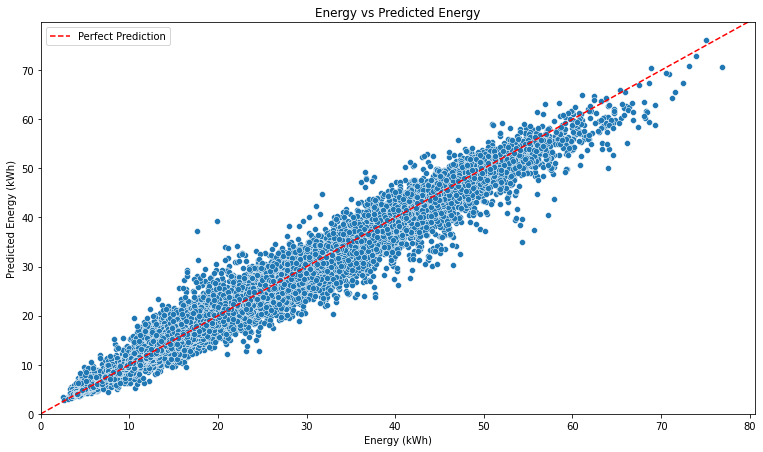

In [58]:
plt.figure(figsize=(12.8, 7.2))

sns.scatterplot(data=energy_df, x="energy", y="energy_pred")
plt.xlabel("Energy (kWh)")
plt.ylabel("Predicted Energy (kWh)")
plt.title("Energy vs Predicted Energy")
plt.xlim(0, None)
plt.ylim(0, None)
plt.plot([0, 100], [0, 100], "r--")
plt.legend(["Perfect Prediction"])
plt.show()

<Figure size 921.6x518.4 with 0 Axes>

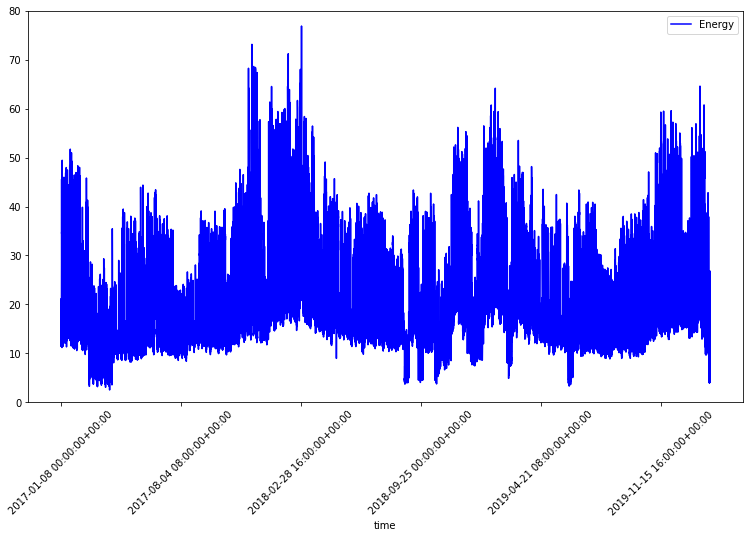

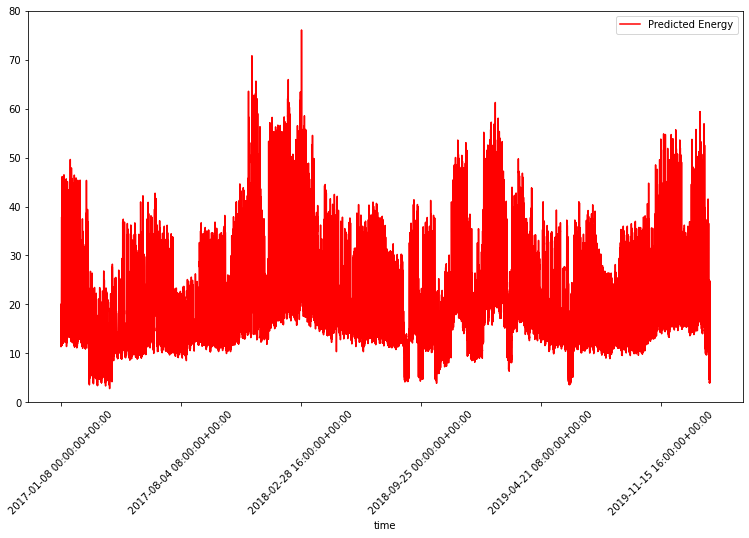

In [74]:
plt.figure(figsize=(12.8, 7.2))

energy_df.plot(y="energy", figsize=(12.8, 7.2), c="b", label="Energy")
plt.ylim(0, 80)
plt.xticks(rotation=45)
energy_df.plot(y="energy_pred", figsize=(12.8, 7.2), c="r", label="Predicted Energy")
plt.ylim(0, 80)
plt.xticks(rotation=45)
plt.show()

### Energy Production

The production of energy of a solar panel is given by the following equation:

$E(t) = A*r(t)*G(t)*\rho$

Where:

* $E(t)$ is the energy produced in time $t$;
* $A$ is the area of the solar panel;
* $r(t)$ is the is the yield of the solar panel in time $t$;
* $G(t)$ is the Solar irradiance at time $t$;
* $\rho$ is the performance of the solar panel.

In [114]:
simulation = energy_df[["energy", "energy_pred"]]
simulation.head()

,energy,energy_pred
time,,
2017-01-08 00:00:00+00:00,12.1005,12.346559
2017-01-08 00:30:00+00:00,15.5335,13.528800
2017-01-08 01:00:00+00:00,15.8120,15.156461
2017-01-08 01:30:00+00:00,15.2760,15.276405
2017-01-08 02:00:00+00:00,15.6635,14.978525


In [115]:
solar_df = pd.read_csv("../data/Solcast_PT30M.csv")
solar_df.head()

,PeriodEnd,PeriodStart,Period,AirTemp,CloudOpacity,Dni,PrecipitableWater,RelativeHumidity,WindDirection10m,WindSpeed10m
0,2007-01-01T01:00:00Z,2007-01-01T00:30:00Z,PT30M,8.0,0.0,0,11.6,81.4,249,9.9
1,2007-01-01T01:30:00Z,2007-01-01T01:00:00Z,PT30M,7.7,0.0,0,11.3,83.3,251,9.7
2,2007-01-01T02:00:00Z,2007-01-01T01:30:00Z,PT30M,7.3,0.0,0,11.1,85.2,253,9.5
3,2007-01-01T02:30:00Z,2007-01-01T02:00:00Z,PT30M,7.0,0.0,0,10.9,87.2,255,9.4
4,2007-01-01T03:00:00Z,2007-01-01T02:30:00Z,PT30M,6.6,0.0,0,10.7,89.2,256,9.2


In [116]:
solar_df["PeriodStart"] = pd.to_datetime(solar_df["PeriodStart"], format="%Y-%m-%d %H:%M:%S", utc=True)
solar_df["PeriodEnd"] = pd.to_datetime(solar_df["PeriodEnd"], format="%Y-%m-%d %H:%M:%S", utc=True)
simulation.reset_index(inplace=True)
simulation["time"] = pd.to_datetime(simulation["time"], format="%Y-%m-%d %H:%M:%S", utc=True)
solar_df.rename(columns={"PeriodEnd": "time"}, inplace=True)
simulation = simulation.merge(solar_df, on="time", how="left")
simulation.set_index("time", inplace=True)
simulation.head()

,energy,energy_pred,PeriodStart,Period,AirTemp,CloudOpacity,Dni,PrecipitableWater,RelativeHumidity,WindDirection10m,WindSpeed10m
time,,,,,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.346559,2017-01-07 23:30:00+00:00,PT30M,8.5,5.3,0,15.7,98.7,257,1.7
2017-01-08 00:30:00+00:00,15.5335,13.528800,2017-01-08 00:00:00+00:00,PT30M,8.4,35.3,0,15.6,98.7,257,1.7
2017-01-08 01:00:00+00:00,15.8120,15.156461,2017-01-08 00:30:00+00:00,PT30M,8.3,47.8,0,15.6,98.7,258,1.7
2017-01-08 01:30:00+00:00,15.2760,15.276405,2017-01-08 01:00:00+00:00,PT30M,8.2,47.8,0,15.5,98.7,260,1.7
2017-01-08 02:00:00+00:00,15.6635,14.978525,2017-01-08 01:30:00+00:00,PT30M,8.1,47.4,0,15.4,98.7,262,1.7


In [117]:
simulation = simulation[["energy", "energy_pred", "Dni"]]
simulation.head()

,energy,energy_pred,Dni
time,,,
2017-01-08 00:00:00+00:00,12.1005,12.346559,0
2017-01-08 00:30:00+00:00,15.5335,13.528800,0
2017-01-08 01:00:00+00:00,15.8120,15.156461,0
2017-01-08 01:30:00+00:00,15.2760,15.276405,0
2017-01-08 02:00:00+00:00,15.6635,14.978525,0


In [118]:
simulation["Dni"] = simulation["Dni"] / 1000 

In [119]:
simulation.describe()

,energy,energy_pred,Dni
count,54049.000000,54049.000000,54049.000000
mean,20.287596,20.277138,0.098700
std,10.314216,10.017663,0.221135
min,2.506500,2.785979,0.000000
25%,12.825000,12.937480,0.000000
50%,17.028000,17.320105,0.000000
75%,25.407000,25.322823,0.017000
max,76.893000,76.088570,0.945000


#### Scenario 1

- Goal to improve self-consumption
- no max battery capacity
- no cost of discharging
- no attention to market price


In [151]:
simulation["production"] = 100 * simulation["Dni"]
simulation.head()

,energy,energy_pred,Dni,production
time,,,,
2017-01-08 00:00:00+00:00,12.1005,12.346559,0.0,0.0
2017-01-08 00:30:00+00:00,15.5335,13.528800,0.0,0.0
2017-01-08 01:00:00+00:00,15.8120,15.156461,0.0,0.0
2017-01-08 01:30:00+00:00,15.2760,15.276405,0.0,0.0
2017-01-08 02:00:00+00:00,15.6635,14.978525,0.0,0.0


In [152]:
simulation.describe()

,energy,energy_pred,Dni,production
count,54049.000000,54049.000000,54049.000000,54049.000000
mean,20.287596,20.277138,0.098700,9.869968
std,10.314216,10.017663,0.221135,22.113494
min,2.506500,2.785979,0.000000,0.000000
25%,12.825000,12.937480,0.000000,0.000000
50%,17.028000,17.320105,0.000000,0.000000
75%,25.407000,25.322823,0.017000,1.700000
max,76.893000,76.088570,0.945000,94.500000


In [159]:
simulation["battery_charge"] = 0
simulation["grid_energy"] = 0
simulation["send_to_grid"] = 0


In [160]:
simulation.head()

,energy,energy_pred,Dni,production,battery_charge,grid_energy,send_to_grid
time,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.346559,0.0,0.0,0,0,0
2017-01-08 00:30:00+00:00,15.5335,13.528800,0.0,0.0,0,0,0
2017-01-08 01:00:00+00:00,15.8120,15.156461,0.0,0.0,0,0,0
2017-01-08 01:30:00+00:00,15.2760,15.276405,0.0,0.0,0,0,0
2017-01-08 02:00:00+00:00,15.6635,14.978525,0.0,0.0,0,0,0


In [167]:
BATTERY_CAP = 16

def baseline_algorithm1(x):
    # energy predicted to consume
    to_consume = x["energy_pred"]

    # if the energy predicted to consume is greater than the energy produced
    if x["production"] < x["energy_pred"]:
        # consume the energy produced
        to_consume -= x["production"]

        # go fetch the rest to the battery
        if to_consume > x["battery_charge"]:
            # if the battery energy is not enough 
            # consume all the energy from the battery
            to_consume -= x["battery_charge"]
            x["battery_charge"] = 0
        else:
            # if the battery energy is enough
            x["battery_charge"] -= to_consume
            to_consume = 0
    else:
        # if the energy predicted to consume is less than the energy produced

        # empty space in the battery
        possible_charge = BATTERY_CAP - x["battery_charge"]
        # add the produced energy to the battery
        x["battery_charge"] += possible_charge
        to_consume -= possible_charge
        # send the rest of the energy to the grid
        x["send_to_grid"] = max(x["production"] - possible_charge, 0)

        # consume the energy predicted to consume
        to_consume = 0
    
    # fetch the rest of the energy to the grid
    x["grid_energy"] = to_consume
    return x

In [168]:
simulation = simulation.apply(baseline_algorithm1, axis=1)
simulation.head()

,energy,energy_pred,Dni,production,battery_charge,grid_energy,send_to_grid
time,,,,,,,
2017-01-08 00:00:00+00:00,12.1005,12.346559,0.0,0.0,0.0,12.346559,0.0
2017-01-08 00:30:00+00:00,15.5335,13.528800,0.0,0.0,0.0,13.528800,0.0
2017-01-08 01:00:00+00:00,15.8120,15.156461,0.0,0.0,0.0,15.156461,0.0
2017-01-08 01:30:00+00:00,15.2760,15.276405,0.0,0.0,0.0,15.276405,0.0
2017-01-08 02:00:00+00:00,15.6635,14.978525,0.0,0.0,0.0,14.978525,0.0


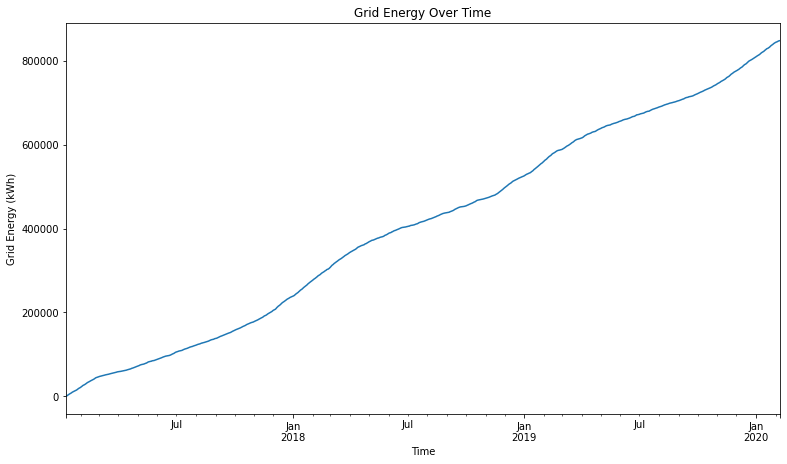

In [169]:
simulation["grid_energy"].cumsum().plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Grid Energy (kWh)")
plt.title("Grid Energy Over Time")
plt.show()

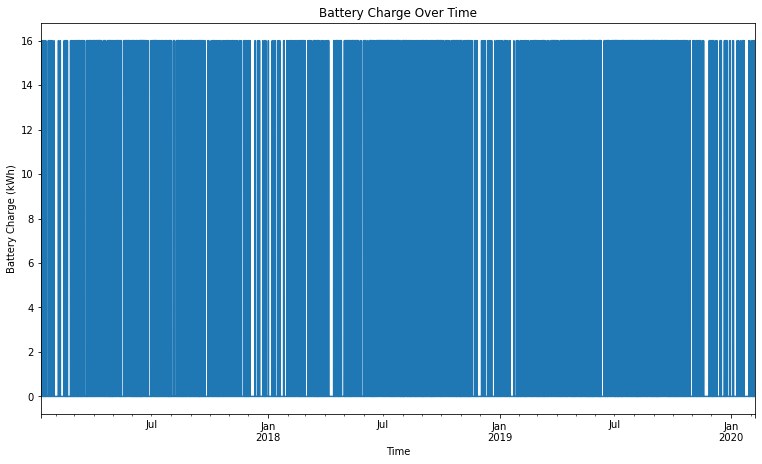

In [170]:
simulation["battery_charge"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Battery Charge (kWh)")
plt.title("Battery Charge Over Time")
plt.show()


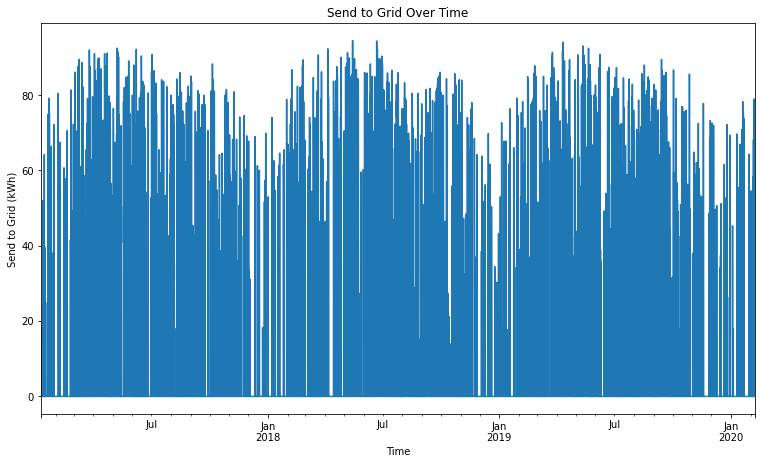

In [171]:
simulation["send_to_grid"].plot(figsize=(12.8, 7.2))
plt.xlabel("Time")
plt.ylabel("Send to Grid (kWh)")
plt.title("Send to Grid Over Time")
plt.show()

In [172]:
simulation.describe()

,energy,energy_pred,Dni,production,battery_charge,grid_energy,send_to_grid
count,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000,54049.000000
mean,20.287596,20.277139,0.098700,9.869968,2.488113,15.689795,8.788348
std,10.314216,10.017663,0.221135,22.113494,5.798251,11.045660,22.122265
min,2.506500,2.785979,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.825000,12.937480,0.000000,0.000000,0.000000,10.409360,0.000000
50%,17.028000,17.320105,0.000000,0.000000,0.000000,14.332101,0.000000
75%,25.407000,25.322823,0.017000,1.700000,0.000000,20.836784,0.000000
max,76.893000,76.088570,0.945000,94.500000,16.000000,76.088570,94.500000
